## Totale 19/6/2017
### Esercizio 2 Punto 2

Alessandro Lodi<br>
Matricola 274425

### Notebook Init

In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class args:
    filename = "atsp18062019.gml"
    scale = 40
    figsize = 10,10

In [4]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Drawing functions

In [5]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()

In [6]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 28 nodes and 756 edges


## mTSP

>**Given**
>A directed graph $G=(N,A)\;$ and a cost $c_{ij} > 0$ for each arc in $A$
>
>**Find**
> A set of routes for $m$ salesmen who all start from and turn back to a home city (depot, node 1) 
 

### mTSP MTZ  Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$
​
Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
u_i - u_j + p x_{ij} &\le p-1 \;\; \forall (i,j) \in A, i,j \not = 1\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [7]:
root = 1

# Number of vehicles
m = 3

# The max number of nodes in the path
p = 10

mtsp_mtz = gb.Model()

x = mtsp_mtz.addVars(G.edges(),
                 obj=[G[i][j]['dist'] for i,j in G.edges()],
                 vtype=gb.GRB.BINARY, name='x')

u = mtsp_mtz.addVars(G.nodes(), obj=0.0, vtype=gb.GRB.CONTINUOUS, lb=1.0, ub=p, name='u')

mtsp_mtz.addConstr(x.sum(root,'*') == m, name = 'OUT-R')
mtsp_mtz.addConstr(x.sum('*',root) == m, name = 'IN-R')

mtsp_mtz.addConstrs((x.sum(i,'*') == 1 for i in G.nodes() if i != root), name='FS')
mtsp_mtz.addConstrs((x.sum('*',i) == 1 for i in G.nodes() if i != root), name='RS')

mtsp_mtz.addConstrs((x[i,j] + x[j,i] <= 1 
                     for i,j in G.edges()
                     if j > i and i != root and j != root ),
                    name='SUB2')

u[root].lb = 0
u[root].ub = 0

mtsp_mtz.addConstrs((u[i] - u[j] + p * x[i,j] <= p - 1 \
                     for i in G.nodes() for j in G.nodes()\
                    if i != j and i != root and j != root and G.has_edge(i,j)), name='MTZ')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

Academic license - for non-commercial use only - expires 2021-08-02
Using license file /opt/gurobi/gurobi.lic


In [8]:
x[root, 2].lb = 1.0
x[root, 15].lb = 1.0
x[root, 20].lb = 1.0

## Strengthening through the Cut Callback

In [9]:
mtsp_mtz._graph = G
mtsp_mtz._vars = x

In [10]:
# SEC costraints with |S|>2
def SEC_cut_callback (model, where):
    if where == gb.GRB.Callback.MIPNODE:
        
        status = model.cbGet(gb.GRB.Callback.MIPNODE_STATUS)
        count = model.cbGet(gb.GRB.Callback.MIPNODE_NODCNT)
        
        if status == gb.GRB.OPTIMAL and count < 10:
            x = model._vars
            xrel = model.cbGetNodeRel(x) 
            G = model._graph
                        
            for i,j in G.edges():
                G[i][j]['capacity'] = xrel[i,j]

            for i in list(G.nodes())[1:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:

                    cutarcs = [(u,v) for u in cut[0] for v in cut[1] if G.has_edge(u,v)]

                    model.cbCut(gb.quicksum(x[i,j] for i,j in cutarcs) >= 1)
                    break

In [11]:
mtsp_mtz.reset()
mtsp_mtz.Params.PreCrush = 1
mtsp_mtz.Params.lazyConstraints = 0
mtsp_mtz.optimize(SEC_cut_callback)

Discarded solution information
Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Parameter lazyConstraints unchanged
   Value: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1109 rows, 784 columns and 4320 nonzeros
Model fingerprint: 0xca679d4d
Variable types: 28 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Presolve removed 205 rows and 109 columns
Presolve time: 0.01s
Presolved: 904 rows, 675 columns, 3606 nonzeros
Variable types: 24 continuous, 651 integer (651 binary)
Found heuristic solution: objective 50980.000000

Root relaxation: objective 1.698750e+04, 108 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

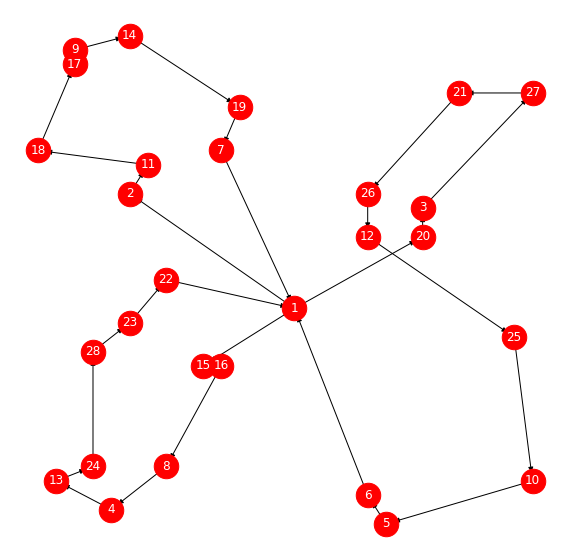

In [12]:
DrawSol(G,x)

In [13]:
q1_sol = 15645.0
print("The cost increase is", mtsp_mtz.objVal - q1_sol)

The cost increase is 2587.0
